# LES Precipitation Forecasting

### Problem Statement
- Develop a hybrid deep learning model that integrates meteorological weather data and satellite imagery to predict future weather forecasts.

### Approach
- Utilized a provided notebook for initial data preparation, including cleaning and feature selection:
  - Removed features with high correlations and excessive NaN values.
- Implemented sliding windows for data input:
  - 24-hour meteorological data and 8-hour image data for next day precipitation prediction.
  - 48-hour meteorological data and 16-hour image data for subsequent day precipitation prediction.
- Addressed multi-class classification by distributing labels into four balanced classes to manage class imbalance.
- Explored multiple model architectures:
  1. ConvLSTM2D + LSTM Shallow
  2. ConvLSTM2D + LSTM Deep
  3. Conv3D + ConvLSTM2D + LSTM Shallow
  4. Conv3D + ConvLSTM2D + LSTM Deep
  - Additionally, a single Conv3D + ConvLSTM2D + LSTM Shallow model was used for the 48-hour window.
- Evaluated models through:
  - Publishing scores and classification reports.
  - Generating plots of Training and Validation Loss/Accuracy.


### Reading the files

In [ ]:
from google.colab import files
files.upload()

from google.colab import drive
drive.mount('/content/drive')

!pip install kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download -d vishalvrv9/meteorological-data

Saving kaggle.json to kaggle (3).json
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
meteorological-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! mkdir train
! unzip meteorological-data.zip -d train
! mkdir unzipped_images

mkdir: cannot create directory ‘train’: File exists
Archive:  meteorological-data.zip
replace train/2006Fall_2017Spring_GOES_meteo_combined.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
mkdir: cannot create directory ‘unzipped_images’: File exists


In [ ]:
#Run only once
"""
import zipfile
zip_image_path = '/content/drive/MyDrive/Final Project Neural Nets/64by64.zip'
output_dir = '/content/drive/MyDrive/Final Project Neural Nets/unzipped_images/'

with zipfile.ZipFile(zip_image_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)
"""

"\nimport zipfile\nzip_image_path = '/content/drive/MyDrive/Final Project Neural Nets/64by64.zip'\noutput_dir = '/content/drive/MyDrive/Final Project Neural Nets/unzipped_images/'\n\nwith zipfile.ZipFile(zip_image_path, 'r') as zip_ref:\n    zip_ref.extractall(output_dir)\n"

In [ ]:
import pandas as pd
from tqdm import tqdm
import cv2
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model, load_model
from keras.layers import Input, LSTM, ConvLSTM2D, Dense, Add, Dropout, Flatten, Reshape
from keras.layers import TimeDistributed, BatchNormalization
from keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

In [ ]:
images = []
output_dir = '/content/drive/MyDrive/Final Project Neural Nets/unzipped_images/64by64_1/'
for idx in tqdm(range(14000)):
    im = cv2.imread(output_dir + str(idx) + '.png')
    if im is None:
        print("Error: Unable to read image at path:", output_dir + str(idx) + '.png')
        # Handle the error (e.g., skip this image, log the error, etc.)
    else:
        # Continue processing the image
        images.append(im[8:-8, 8:-8, 0])

100%|██████████| 14000/14000 [1:46:21<00:00,  2.19it/s]


In [ ]:
les = pd.read_csv(r"/content/train/2006Fall_2017Spring_GOES_meteo_combined.csv")


### Pre-Processing Begins
1. Dropping all the higly co-related features
2. Dropping all the features that have a significant number of NaN or null values.

Took Prof notebook as source of truth.

In [ ]:
# Renaming
les.rename(columns={ "Temp (F)": "Temp_F", "RH (%)": "RH_pct",
                   "Dewpt (F)" : "Dewpt_F", "Wind Spd (mph)" : "Wind_Spd_mph",
                   "Wind Direction (deg)" : "Wind_Direction_deg", "Peak Wind Gust(mph)" : "Peak_Wind_Gust_mph",
                   "Low Cloud Ht (ft)" : "Low_Cloud_Ht_ft", "Med Cloud Ht (ft)" : "Med_Cloud_Ht_ft",
                   "High Cloud Ht (ft)" : "High_Cloud_Ht_ft", "Visibility (mi)" : "Visibility_mi",
                   "Atm Press (hPa)" : "Atm_Press_hPa", "Sea Lev Press (hPa)" : "Sea_Lev_Press_hPa",
                   "Altimeter (hPa)" : "Altimeter_hPa", "Precip (in)" : "Precip_in",
                   "Wind Chill (F)" : "Wind_Chill_F", "Heat Index (F)" : "Heat_Index_F",
                   } , inplace = True)

les.head(50)

,Date_UTC,Time_UTC,Date_CST,Time_CST,File_name_for_1D_lake,File_name_for_2D_lake,Lake_data_1D,Lake_data_2D,Temp_F,RH_pct,...,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in,Wind_Chill_F,Heat_Index_F
0,2006-10-01,00:00,2006-09-30,00:00,goes11.2006.10.01.0000.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0000.v01.nc-var1-t0.csv.csv,"[0.0075, 0.0025, 0.0, 0.005, 0.0, 0.005, nan, ...","[array([ nan, nan, nan, nan, nan...",48,86,...,4100,4800,7000,10,984.0,1007.00,1006.80,0.00,45,NC
1,2006-10-01,01:00,2006-09-30,01:00,goes11.2006.10.01.0100.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0100.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0025, 0.0025, nan, 0.0, nan, 0...","[array([ nan, nan, nan, nan, nan...",48,86,...,6000,m,m,10,983.7,1006.50,1006.40,0.00,44,NC
2,2006-10-01,02:00,2006-09-30,02:00,goes11.2006.10.01.0200.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0200.v01.nc-var1-t0.csv.csv,"[0.0, nan, 0.0075, nan, nan, 0.0025, nan, nan,...","[array([nan, nan, nan, nan, nan, nan, nan, nan...",48,86,...,5500,11000,m,10,982.7,1005.70,1005.40,0.00,45,NC
3,2006-10-01,03:00,2006-09-30,03:00,goes11.2006.10.01.0300.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0300.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0025, 0.0, 0.0075, nan, 0.005,...","[array([nan, nan, nan, nan, nan, nan, nan, nan...",48,86,...,6000,m,m,10,982.0,1005.10,1004.70,0.00,44,NC
4,2006-10-01,04:00,2006-09-30,04:00,goes11.2006.10.01.0400.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0400.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0, nan, 0.0075, 0.0, nan, nan,...","[array([ nan, nan, nan, nan, nan...",48,89,...,2200,3500,m,8,982.0,1004.90,1004.70,0.02,46,NC
5,2006-10-01,05:00,2006-09-30,05:00,goes11.2006.10.01.0500.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0500.v01.nc-var1-t0.csv.csv,"[nan, nan, 0.0075, nan, nan, 0.0025, 0.0025, 0...","[array([nan, nan, nan, nan, nan, nan, nan, nan...",48,89,...,2700,5500,7500,10,981.7,1004.60,1004.40,0.01,45,NC
6,2006-10-01,06:00,2006-10-01,06:00,goes11.2006.10.01.0600.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0600.v01.nc-var1-t0.csv.csv,"[nan, 0.0, 0.0075, 0.005, 0.0025, 0.005, 0.005...","[array([nan, nan, nan, nan, nan, nan, nan, nan...",42,95,...,4600,m,m,8,991.7,1014.80,1014.60,0.00,NC,NC
7,2006-10-01,07:00,2006-10-01,07:00,goes11.2006.10.01.0700.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0700.v01.nc-var1-t0.csv.csv,"[nan, 0.0025, 0.005, 0.0025, nan, nan, nan, 0....","[array([nan, nan, nan, nan, nan, nan, nan, nan...",43,96,...,3900,m,m,10,992.3,1015.60,1015.20,0.00,NC,NC
8,2006-10-01,08:00,2006-10-01,08:00,NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",[nan],48,92,...,3600,m,m,10,993.0,1016.30,1015.90,0.00,NC,NC
9,2006-10-01,09:00,2006-10-01,09:00,NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",[nan],55,59,...,3600,m,m,10,993.7,1016.90,1016.60,0.00,NC,NC


In [ ]:
les = les.replace(['m', 'M'], '0')
les = les.drop(['Wind_Chill_F', 'Heat_Index_F'], axis=1)
les = les.reset_index(drop=True)
les = les.dropna(subset = ['Temp_F'])
les.columns


Index(['Date_UTC', 'Time_UTC', 'Date_CST', 'Time_CST', 'File_name_for_1D_lake',
       'File_name_for_2D_lake', 'Lake_data_1D', 'Lake_data_2D', 'Temp_F',
       'RH_pct', 'Dewpt_F', 'Wind_Spd_mph', 'Wind_Direction_deg',
       'Peak_Wind_Gust_mph', 'Low_Cloud_Ht_ft', 'Med_Cloud_Ht_ft',
       'High_Cloud_Ht_ft', 'Visibility_mi', 'Atm_Press_hPa',
       'Sea_Lev_Press_hPa', 'Altimeter_hPa', 'Precip_in'],
      dtype='object')

In [ ]:
meteo_les = les.drop(
    [ 'Date_UTC', 'Time_UTC', 'Date_CST', 'Time_CST', 'File_name_for_1D_lake', 'File_name_for_2D_lake',
     'Lake_data_1D', 'Lake_data_2D', 'Dewpt_F', 'Peak_Wind_Gust_mph', 'Altimeter_hPa' ], axis=1)

In [ ]:
meteo_les.head()


,Temp_F,RH_pct,Wind_Spd_mph,Wind_Direction_deg,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Precip_in
0,48,86,7,150,4100,4800,7000,10,984.0,1007.00,0.00
1,48,86,8,150,6000,0,0,10,983.7,1006.50,0.00
2,48,86,6,0,5500,11000,0,10,982.7,1005.70,0.00
3,48,86,8,150,6000,0,0,10,982.0,1005.10,0.00
4,48,89,5,0,2200,3500,0,8,982.0,1004.90,0.02


In [ ]:
len(meteo_les)


47882

### Slice on the weather data

- Meterological Slice - 24 hours (1 day)
- Image Slice - 8 hours (1 day)

##### First we work on the training data

In [ ]:
weather_train_batched = tf.keras.preprocessing.timeseries_dataset_from_array(meteo_les[0:30000], None, 24, sequence_stride=24,
                                                                   sampling_rate=1, batch_size=30000)
for batch in weather_train_batched:
    print(batch.shape)
    print('--')

(1250, 24, 11)
--


In [ ]:
def convert_byte_tensor_to_float(tensor):
    string_tensor = tf.strings.regex_replace(tensor, '^b\'(.*)\'$', '\\1')
    float_tensor = tf.strings.to_number(string_tensor, out_type=tf.float32)
    return float_tensor

In [ ]:
weather_train = None
for batch in weather_train_batched:
    weather_train = batch
    print(weather_train.shape)
    print('--')

(1250, 24, 11)
--


In [ ]:
weather_train = tf.map_fn(
    lambda batch: tf.map_fn(
        lambda sample: convert_byte_tensor_to_float(sample),
        batch,
        dtype=tf.float32),
    weather_train,
    dtype=tf.float32)

In [ ]:
weather_train.shape

TensorShape([1250, 24, 11])

In [ ]:
rain_train = []

for sample in weather_train:
    last_column = sample[:, -1]

    # Sum the values in the last column
    rain_sum = tf.reduce_sum(last_column)

    # Append the sum to rain_train
    rain_train.append(rain_sum)

rain_train = tf.stack(rain_train)

##### Generating 4 labels

##### Trying to evade label imbalance as much as possible


 Labels for no_rain, little_rain, medium_rain, tons_of_rain
- < 0.01 - no rain => class 0
- 0.01 - 0.05 - little rain => class 1
- 0.05 - 0.1 - medium rain => class 2
- >0.1 - tons of rain => class 3

In [ ]:
#Building only for the train_data
unique, _, counts = tf.unique_with_counts(rain_train)

print(sorted(unique.numpy()))
print(unique.numpy())
print(counts.numpy())

[0.0, 0.01, 0.02, 0.03, 0.04, 0.049999997, 0.05, 0.059999995, 0.06, 0.060000002, 0.06999999, 0.07, 0.07999999, 0.08, 0.089999996, 0.09, 0.099999994, 0.1, 0.109999985, 0.10999999, 0.11, 0.11999999, 0.12, 0.120000005, 0.13, 0.13000001, 0.13999999, 0.14, 0.14999999, 0.15, 0.16, 0.16000001, 0.16999999, 0.17, 0.17999998, 0.17999999, 0.18, 0.19, 0.19000001, 0.19999999, 0.21, 0.21000001, 0.21999998, 0.22, 0.22000001, 0.22999999, 0.23, 0.24, 0.24000001, 0.24999999, 0.25, 0.26, 0.26999998, 0.27999997, 0.28, 0.29, 0.29999998, 0.3, 0.31, 0.32, 0.32999998, 0.33, 0.33999997, 0.34, 0.34999996, 0.35, 0.36, 0.37, 0.38, 0.39, 0.39999998, 0.4, 0.42, 0.43, 0.44, 0.45, 0.46999997, 0.48, 0.49, 0.51, 0.53, 0.56, 0.59, 0.59000003, 0.6, 0.62, 0.71, 0.73, 0.73999995, 0.77, 0.85999995, 0.95000005, 0.99, 1.1, 1.47, 1.78, 2.02]
[0.03       0.01       2.02       0.34       0.         0.05
 0.34999996 0.25       0.3        0.14       0.04       0.22999999
 0.09       0.24       0.10999999 0.48       0.02       0.24

In [ ]:
count_under_001 = tf.reduce_sum(tf.cast(tf.math.less(rain_train, 0.001), tf.int32))
count_under_05 = tf.reduce_sum(tf.cast(tf.math.less(rain_train, 0.05), tf.int32))

count_gt_05 = tf.reduce_sum(tf.cast(tf.math.greater_equal(rain_train, 0.05), tf.int32))
count_gt_1 = tf.reduce_sum(tf.cast(tf.math.greater_equal(rain_train, 0.1), tf.int32))

print(count_under_001.numpy())
print(count_under_05.numpy())
print(count_gt_05.numpy())
print(count_gt_1.numpy())

628
971
279
192


In [ ]:
rain_train_b = tf.where(rain_train > 0.1, 3,
                        tf.where(rain_train > 0.05, 2,
                                 tf.where(rain_train > 0.001, 1, 0)))

In [ ]:
pd.Series(rain_train_b.numpy()).value_counts()


0    628
1    347
3    190
2     85
Name: count, dtype: int64

In [ ]:
weather_train = weather_train[:, :, :-1]
print(weather_train.shape)

(1250, 24, 10)


#### Scaling our Train dataset

In [ ]:
scaler = MinMaxScaler()

n_samples, n_timesteps, n_features = weather_train.shape
weather_train= tf.reshape(weather_train, [n_samples * n_timesteps, n_features])
weather_train = weather_train.numpy()
weather_train = scaler.fit_transform(weather_train)
weather_train = tf.reshape(weather_train, [n_samples, n_timesteps, n_features]).numpy()

#### Now, we work on the validaiton dataset

In [ ]:
#Here
weather_val_batched = tf.keras.preprocessing.timeseries_dataset_from_array(meteo_les[-7500:], None, 24, sequence_stride=24,
                                                                   sampling_rate=1, batch_size=7500)

In [ ]:
weather_val = None
for batch in weather_val_batched:
    weather_val = batch
    print(weather_val.shape)
    print('--')

(312, 24, 11)
--


In [ ]:
weather_val = tf.map_fn(
    lambda batch: tf.map_fn(
        lambda sample: convert_byte_tensor_to_float(sample),
        batch,
        dtype=tf.float32),
    weather_val,
    dtype=tf.float32)

In [ ]:
rain_val= []

for sample in weather_val:
    last_column = sample[:, -1]

    rain_sum = tf.reduce_sum(last_column)

    rain_val.append(rain_sum)

rain_val = tf.stack(rain_val)

In [ ]:
#Generating 4 labels for our validation dataset
rain_val_b = tf.where(rain_val > 0.1, 3,
                        tf.where(rain_val > 0.05, 2,
                                 tf.where(rain_val > 0.001, 1, 0)))

In [ ]:
weather_val = weather_val[:, :, :-1]


In [ ]:
# Scaling validation dataset
n_samples_val, n_timesteps_val, n_features_val = weather_val.shape
weather_val = tf.reshape(weather_val, [n_samples_val * n_timesteps_val, n_features_val])
weather_val = weather_val.numpy()
weather_val = scaler.transform(weather_val)
weather_val = tf.reshape(weather_val, [n_samples_val, n_timesteps_val, n_features_val]).numpy()

In [ ]:
weather_val.shape

(312, 24, 10)

## Processing Cloud Images now

In [ ]:
cloud_train_batched = tf.keras.preprocessing.timeseries_dataset_from_array(images[:10000], None, 8, sequence_stride=8,
                                                                           sampling_rate=1, batch_size=10000)

cloud_val_batched = tf.keras.preprocessing.timeseries_dataset_from_array(images[:2500], None, 8, sequence_stride=8,
                                                                         sampling_rate=1, batch_size=2500)

print(cloud_train_batched)
print(cloud_val_batched)

<_BatchDataset element_spec=TensorSpec(shape=(None, None, 48, 48), dtype=tf.uint8, name=None)>
<_BatchDataset element_spec=TensorSpec(shape=(None, None, 48, 48), dtype=tf.uint8, name=None)>


In [ ]:
cloud_train = None
for batch in cloud_train_batched:
    cloud_train = batch
    cloud_train = np.expand_dims(cloud_train, axis=-1)
    print(cloud_train.shape)
    cloud_train = cloud_train / 255
    print('--')

(1250, 8, 48, 48, 1)
--


In [ ]:
cloud_val = None
for batch in cloud_val_batched:
    cloud_val = batch
    cloud_val = np.expand_dims(cloud_val, axis=-1)
    print(cloud_val.shape)
    cloud_val = cloud_val / 255
    print('--')

(312, 8, 48, 48, 1)
--


In [ ]:
# Assign rain train c as array from rain train b
rain_train_c = rain_train_b.numpy()
print(rain_train_c.shape)

rain_val_c = rain_val_b.numpy()
print(rain_val_c.shape)

(1250,)
(312,)


In [ ]:
rain_train_c_mod = [rain_train_c[x+1] for x in range(len(rain_train_c)-1)]
print(len(rain_train_c_mod))
rain_val_c_mod = [rain_val_c[x+1] for x in range(len(rain_val_c)-1)]
print(len(rain_val_c_mod))

1249
311


In [ ]:
cloud_train.shape, rain_train_c.shape, cloud_val.shape, rain_val_c.shape

((1250, 8, 48, 48, 1), (1250,), (312, 8, 48, 48, 1), (312,))

In [ ]:
# Drop the last value from each of the validation datasets
weather_val = weather_val[:-1]
cloud_val = cloud_val[:-1]
rain_val_b_mod = rain_val_b[:-1]

#Drop the last value from each of the training datasets
weather_train = weather_train[:-1]
cloud_train = cloud_train[:-1]

In [ ]:
weather_train = np.asarray(weather_train)
cloud_train = np.asarray(cloud_train)
rain_train_c_mod = np.asarray(rain_train_c_mod)

weather_val = np.asarray(weather_val)
cloud_val = np.asarray(cloud_val)
rain_val_c_mod = np.asarray(rain_val_c_mod)

### Finally, all our dimensions

In [ ]:
print(weather_train.shape, cloud_train.shape, rain_train_c_mod.shape, weather_val.shape, cloud_val.shape, rain_val_c_mod.shape)

(1249, 24, 10) (1249, 8, 48, 48, 1) (1249,) (311, 24, 10) (311, 8, 48, 48, 1) (311,)


# The Modeling Part

In [ ]:
#First, we need to one-hot encode our labels
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)

rain_train_c_mod_ohe = encoder.fit_transform(rain_train_c_mod.reshape(-1, 1))
rain_val_c_mod_ohe = encoder.fit_transform(rain_val_c_mod.reshape(-1, 1))

rain_train_c_mod_ohe.shape, rain_val_c_mod_ohe.shape

((1249, 4), (311, 4))

In [ ]:
#Creating the train function for both our approaches. Just boiler plate code to reduce code blocks
def train(checkpoint_path,model,epoch_count=10):
    checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1)

    # Check if a checkpoint already exists
    if os.path.exists(checkpoint_path):
        print("Loading the last checkpoint.")
        model.load_weights(checkpoint_path)

    # Fit the model
    history = model.fit(
        [weather_train, cloud_train],
        rain_train_c_mod_ohe,
        epochs=epoch_count,
        batch_size=10,
        validation_data=([weather_val, cloud_val], rain_val_c_mod_ohe),
        # class_weight=class_weight_dict,
        callbacks=[checkpoint_callback])
    return history

In [ ]:
# Boiler plate code again - this is to create a common function for plotting across all models

import matplotlib.pyplot as plt
import numpy as np


def plot_history(all_histories):
    # Find the maximum number of epochs among all histories
    max_epochs = max(len(h.history['loss']) for h in all_histories)

    # Initialize lists to store average metrics for each epoch
    avg_train_loss = [0] * max_epochs
    avg_val_loss = [0] * max_epochs
    avg_train_acc = [0] * max_epochs
    avg_val_acc = [0] * max_epochs
    count_per_epoch = [0] * max_epochs  # To count actual histories per epoch for correct averaging

    # Aggregate metrics across all histories for each epoch
    for h in all_histories:
        for epoch in range(len(h.history['loss'])):
            avg_train_loss[epoch] += h.history['loss'][epoch]
            avg_val_loss[epoch] += h.history['val_loss'][epoch]
            avg_train_acc[epoch] += h.history['accuracy'][epoch]
            avg_val_acc[epoch] += h.history['val_accuracy'][epoch]
            count_per_epoch[epoch] += 1

    # Normalize to get the average
    avg_train_loss = [total / count if count > 0 else 0 for total, count in zip(avg_train_loss, count_per_epoch)]
    avg_val_loss = [total / count if count > 0 else 0 for total, count in zip(avg_val_loss, count_per_epoch)]
    avg_train_acc = [total / count if count > 0 else 0 for total, count in zip(avg_train_acc, count_per_epoch)]
    avg_val_acc = [total / count if count > 0 else 0 for total, count in zip(avg_val_acc, count_per_epoch)]

    # Plotting the results
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(avg_train_loss, label='Average Train Loss')
    plt.plot(avg_val_loss, label='Average Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.plot(avg_train_acc, label='Average Train Accuracy')
    plt.plot(avg_val_acc, label='Average Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

### First Approach: Conv2D + LSTM in an Encoder Decoder Architecture

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Dropout, ConvLSTM2D, Flatten, BatchNormalization, Dense, Reshape, Add, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

conv2d_lstm_model_checkpoint_path = r'/content/drive/MyDrive/Final Project Neural Nets/checkpoint/conv2d_lstm/model_checkpoint1.h5'

# Define input layers with specified shapes
meteorological_input = Input(shape=(24, 10))
cloud_input = Input(shape=(8, 48, 48, 1))

## Encoder Layers

# LSTM Encoder for Meteorological Data
meteorological_lstm = LSTM(128, return_sequences=True)(meteorological_input)
meteorological_lstm = Dropout(0.3)(meteorological_lstm)
meteorological_lstm = LSTM(64, return_sequences=False)(meteorological_lstm)
meteorological_lstm = Dropout(0.3)(meteorological_lstm)

# ConvLSTM Encoder for Cloud Data
cloud_convlstm_1 = ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=True)(cloud_input)
cloud_convlstm_1 = Dropout(0.3)(cloud_convlstm_1)
cloud_convlstm_3 = ConvLSTM2D(filters=128, kernel_size=(3, 3), padding='same', return_sequences=True)(cloud_convlstm_1)
cloud_flattened = TimeDistributed(Flatten())(cloud_convlstm_3)
cloud_convlstm_output = LSTM(64, return_sequences=False)(cloud_flattened)
cloud_convlstm_output = BatchNormalization()(cloud_convlstm_output)

# Combine the outputs of the LSTM and ConvLSTM layers
combined_features = Add()([meteorological_lstm, cloud_convlstm_output])

## Decoder Layers
decoder_lstm_1 = LSTM(128, return_sequences=True)(Reshape((1, 64))(combined_features))
decoder_lstm_1 = Dropout(0.3)(decoder_lstm_1)
decoder_lstm_2 = LSTM(64, return_sequences=False)(decoder_lstm_1)
decoder_lstm_2 = Dropout(0.3)(decoder_lstm_2)

# Output layer
output = Dense(4, activation='softmax')(decoder_lstm_2)

# Define the model
conv2d_lstm_model = Model(inputs=[meteorological_input, cloud_input], outputs=output)

# Set new learning rate and compile the model
new_learning_rate = 0.0001
optimizer = Adam(learning_rate=new_learning_rate)
conv2d_lstm_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
conv2d_lstm_model.summary()



Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_28 (InputLayer)       [(None, 8, 48, 48, 1)]       0         []                            
                                                                                                  
 conv_lstm2d_26 (ConvLSTM2D  (None, 8, 48, 48, 32)        38144     ['input_28[0][0]']            
 )                                                                                                
                                                                                                  
 input_27 (InputLayer)       [(None, 24, 10)]             0         []                            
                                                                                                  
 dropout_75 (Dropout)        (None, 8, 48, 48, 32)        0         ['conv_lstm2d_26[0][0]'

In [ ]:
#Training the model
conv2d_lstm_model_history = []
conv2d_lstm_model_history.append(train(conv2d_lstm_model_checkpoint_path, conv2d_lstm_model, 25 ))

Epoch 1/25
125/125 [==============================] - ETA: 0s - loss: 1.3391 - accuracy: 0.4251
Epoch 1: val_loss improved from inf to 1.26275, saving model to /content/drive/MyDrive/Final Project Neural Nets/checkpoint/conv2d_lstm/model_checkpoint1.h5
125/125 [==============================] - 40s 221ms/step - loss: 1.3391 - accuracy: 0.4251 - val_loss: 1.2627 - val_accuracy: 0.5595
Epoch 2/25
125/125 [==============================] - ETA: 0s - loss: 1.2270 - accuracy: 0.5020
Epoch 2: val_loss improved from 1.26275 to 1.13049, saving model to /content/drive/MyDrive/Final Project Neural Nets/checkpoint/conv2d_lstm/model_checkpoint1.h5
125/125 [==============================] - 28s 227ms/step - loss: 1.2270 - accuracy: 0.5020 - val_loss: 1.1305 - val_accuracy: 0.5595
Epoch 3/25
125/125 [==============================] - ETA: 0s - loss: 1.1783 - accuracy: 0.5028
Epoch 3: val_loss did not improve from 1.13049
125/125 [==============================] - 25s 201ms/step - loss: 1.1783 - accu

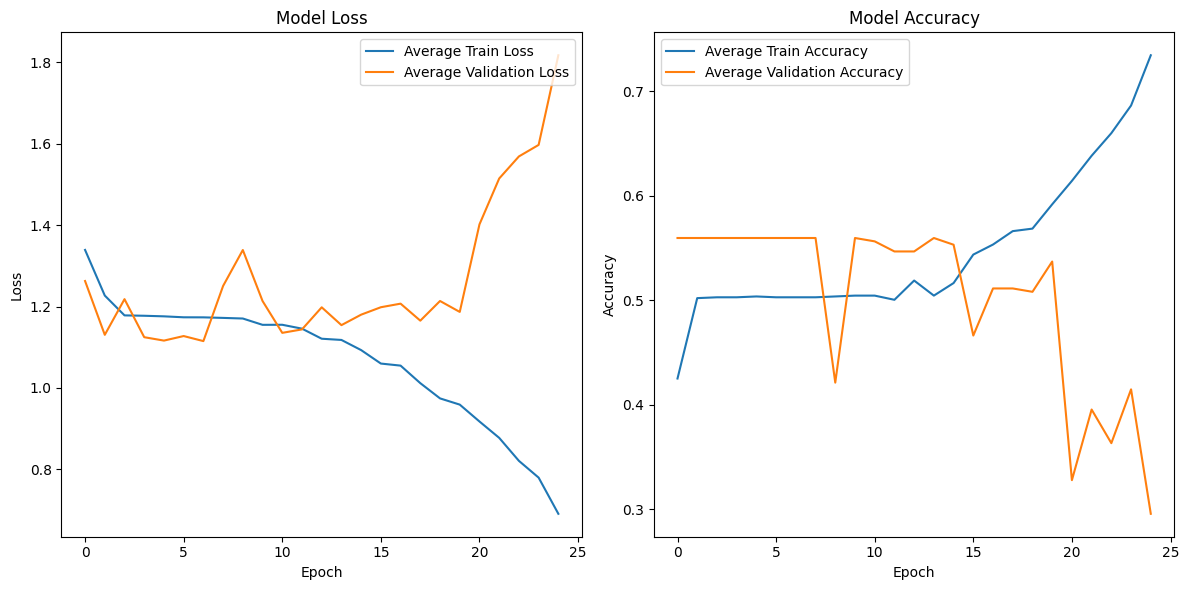

In [ ]:
#No point in training this further, graphs to understand
plot_history(conv2d_lstm_model_history)

#### Just evaluating our first appraoch below

In [ ]:
# Generate the classification_report
predictions = conv2d_lstm_model.predict([weather_val, cloud_val])
# Convert probabilities to class labels
predicted_labels = np.argmax(predictions, axis=-1)
predicted_labels.shape
from sklearn.metrics import classification_report
# Compare predicted labels with true labels
print(classification_report(rain_val_b_mod, predicted_labels))


10/10 [==============================] - 3s 141ms/step
              precision    recall  f1-score   support

           0       0.63      0.44      0.52       149
           1       0.34      0.48      0.40        93
           2       0.00      0.00      0.00        21
           3       0.20      0.27      0.23        48

    accuracy                           0.40       311
   macro avg       0.29      0.30      0.29       311
weighted avg       0.43      0.40      0.40       311



In [ ]:
pred_df = pd.DataFrame([predicted_labels.flatten(), rain_val_c_mod]).T
pred_df.columns = ['predicted', 'actual']
pred_df["Predictions_correct"] = pred_df["predicted"] == pred_df["actual"]
print(pred_df[pred_df['actual'] == 0].value_counts())
print(pred_df[pred_df['actual'] == 1].value_counts())
print(pred_df[pred_df['actual'] == 2].value_counts())
print(pred_df[pred_df['actual'] == 3].value_counts())

predicted  actual  Predictions_correct
1          0       False                  83
0          0       True                   55
3          0       False                  30
2          0       False                   6
Name: count, dtype: int64
predicted  actual  Predictions_correct
1          1       True                   30
0          1       False                  25
3          1       False                  22
2          1       False                   1
Name: count, dtype: int64
predicted  actual  Predictions_correct
0          2       False                  8
1          2       False                  7
3          2       False                  6
Name: count, dtype: int64
predicted  actual  Predictions_correct
0          3       False                  17
1          3       False                  13
3          3       True                    7
2          3       False                   1
Name: count, dtype: int64


#### MODIFIED First Approach: Conv2D + LSTM in an Encoder Decoder Architecture

Adding more layers, we think that maybe the first model was too simple and underfitting.

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Dropout, ConvLSTM2D, Flatten, BatchNormalization, Dense, Reshape, Add, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

conv2d_lstm_model_deeper_checkpoint_path = r'/content/drive/MyDrive/Final Project Neural Nets/checkpoint/conv2d_lstm/model_checkpoint_deeper1.h5'

# Define input layers with specified shapes
meteorological_input = Input(shape=(24, 10))
cloud_input = Input(shape=(8, 48, 48, 1))

## Encoder Layers

# LSTM Encoder for Meteorological Data
meteorological_lstm1 = LSTM(128, return_sequences=True)(meteorological_input)
meteorological_dropout1 = Dropout(0.3)(meteorological_lstm1)
meteorological_lstm2 = LSTM(128, return_sequences=True)(meteorological_dropout1)
meteorological_dropout2 = Dropout(0.3)(meteorological_lstm2)
meteorological_lstm3 = LSTM(64, return_sequences=False)(meteorological_dropout2)
meteorological_dropout3 = Dropout(0.3)(meteorological_lstm3)

# ConvLSTM Encoder for Cloud Data
cloud_convlstm1 = ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=True)(cloud_input)
cloud_dropout1 = Dropout(0.3)(cloud_convlstm1)
cloud_convlstm2 = ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True)(cloud_dropout1)
cloud_dropout2 = Dropout(0.3)(cloud_convlstm2)
cloud_convlstm3 = ConvLSTM2D(filters=128, kernel_size=(3, 3), padding='same', return_sequences=True)(cloud_dropout2)
cloud_dropout3 = Dropout(0.3)(cloud_convlstm3)
cloud_flattened = TimeDistributed(Flatten())(cloud_dropout3)
cloud_convlstm_output = LSTM(64, return_sequences=False)(cloud_flattened)
cloud_batchnorm = BatchNormalization()(cloud_convlstm_output)

# Combine the outputs of the LSTM and ConvLSTM layers
combined_features = Add()([meteorological_dropout3, cloud_batchnorm])

## Decoder Layers
decoder_reshape = Reshape((1, 64))(combined_features)
decoder_lstm1 = LSTM(128, return_sequences=True)(decoder_reshape)
decoder_dropout1 = Dropout(0.3)(decoder_lstm1)
decoder_lstm2 = LSTM(64, return_sequences=False)(decoder_dropout1)
decoder_dropout2 = Dropout(0.3)(decoder_lstm2)

# Output layer
output = Dense(4, activation='softmax')(decoder_dropout2)

# Define the model
conv2d_lstm_model_deeper = Model(inputs=[meteorological_input, cloud_input], outputs=output)

# Set new learning rate and compile the model
new_learning_rate = 0.0001
optimizer = Adam(learning_rate=new_learning_rate)
conv2d_lstm_model_deeper.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
conv2d_lstm_model_deeper.summary()


Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_34 (InputLayer)       [(None, 8, 48, 48, 1)]       0         []                            
                                                                                                  
 conv_lstm2d_33 (ConvLSTM2D  (None, 8, 48, 48, 32)        38144     ['input_34[0][0]']            
 )                                                                                                
                                                                                                  
 dropout_95 (Dropout)        (None, 8, 48, 48, 32)        0         ['conv_lstm2d_33[0][0]']      
                                                                                                  
 input_33 (InputLayer)       [(None, 24, 10)]             0         []                     

In [ ]:
#Training the model
conv2d_lstm_model_deeper_history = []
conv2d_lstm_model_deeper_history.append(train(conv2d_lstm_model_deeper_checkpoint_path, conv2d_lstm_model_deeper, 25 ))

Epoch 1/25
125/125 [==============================] - ETA: 0s - loss: 1.3418 - accuracy: 0.4355
Epoch 1: val_loss improved from inf to 1.27946, saving model to /content/drive/MyDrive/Final Project Neural Nets/checkpoint/conv2d_lstm/model_checkpoint_deeper1.h5
125/125 [==============================] - 54s 300ms/step - loss: 1.3418 - accuracy: 0.4355 - val_loss: 1.2795 - val_accuracy: 0.5595
Epoch 2/25
125/125 [==============================] - ETA: 0s - loss: 1.2386 - accuracy: 0.5036
Epoch 2: val_loss improved from 1.27946 to 1.13125, saving model to /content/drive/MyDrive/Final Project Neural Nets/checkpoint/conv2d_lstm/model_checkpoint_deeper1.h5
125/125 [==============================] - 37s 299ms/step - loss: 1.2386 - accuracy: 0.5036 - val_loss: 1.1312 - val_accuracy: 0.5595
Epoch 3/25
125/125 [==============================] - ETA: 0s - loss: 1.1822 - accuracy: 0.5028
Epoch 3: val_loss improved from 1.13125 to 1.11194, saving model to /content/drive/MyDrive/Final Project Neural 

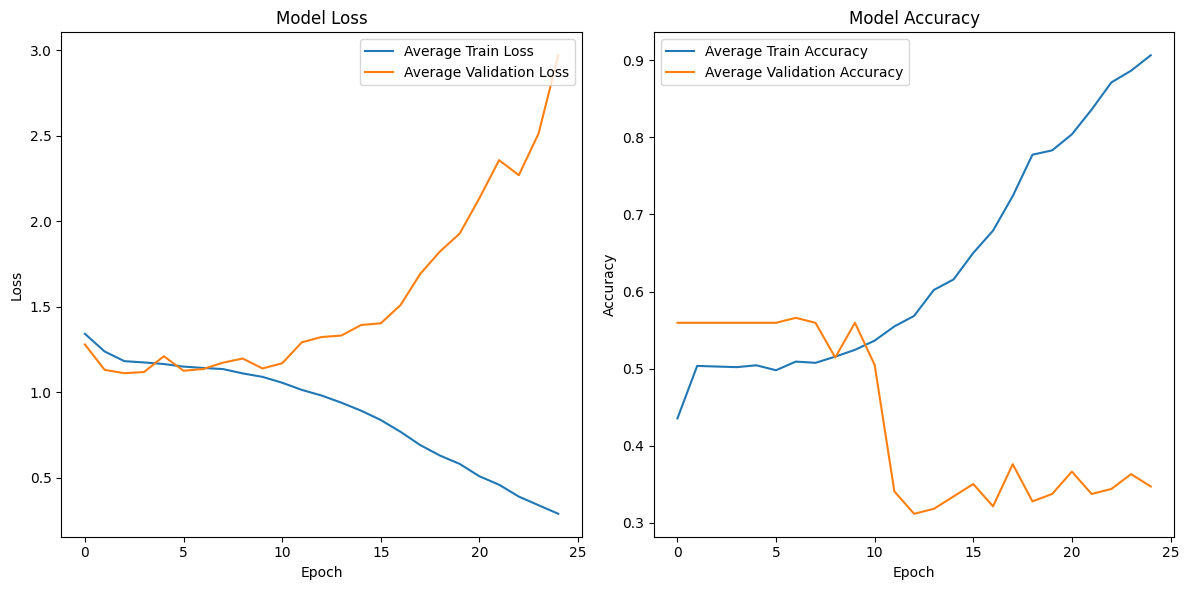

In [ ]:
plot_history(conv2d_lstm_model_deeper_history)

In [ ]:
# Generate the classification_report
predictions = conv2d_lstm_model_deeper.predict([weather_val, cloud_val])
# Convert probabilities to class labels
predicted_labels = np.argmax(predictions, axis=-1)
predicted_labels.shape
from sklearn.metrics import classification_report
# Compare predicted labels with true labels
print(classification_report(rain_val_b_mod, predicted_labels))

pred_df = pd.DataFrame([predicted_labels.flatten(), rain_val_c_mod]).T
pred_df.columns = ['predicted', 'actual']
pred_df["Predictions_correct"] = pred_df["predicted"] == pred_df["actual"]
print(pred_df[pred_df['actual'] == 0].value_counts())
print(pred_df[pred_df['actual'] == 1].value_counts())
print(pred_df[pred_df['actual'] == 2].value_counts())
print(pred_df[pred_df['actual'] == 3].value_counts())


10/10 [==============================] - 1s 157ms/step
              precision    recall  f1-score   support

           0       0.63      0.44      0.52       149
           1       0.34      0.48      0.40        93
           2       0.00      0.00      0.00        21
           3       0.20      0.27      0.23        48

    accuracy                           0.40       311
   macro avg       0.29      0.30      0.29       311
weighted avg       0.43      0.40      0.40       311

predicted  actual  Predictions_correct
1          0       False                  83
0          0       True                   55
3          0       False                  30
2          0       False                   6
Name: count, dtype: int64
predicted  actual  Predictions_correct
1          1       True                   30
0          1       False                  25
3          1       False                  22
2          1       False                   1
Name: count, dtype: int64
predicted  actual  P

#### Second Approach: Conv3D_LSTM + LSTM in an Encoder Decoder Architecture

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, ConvLSTM2D, Flatten, TimeDistributed, Add, Reshape, Dense, BatchNormalization, Conv3D
from tensorflow.keras.optimizers import Adam

conv3d_2d_lstm_model_checkpoint_path = r'/content/drive/MyDrive/Final Project Neural Nets/checkpoint/conv_3d_2d_lstm/model_checkpoint1.h5'

# Defining input dimensions
weather_input = Input(shape=(24, 10))
satellite_input = Input(shape=(8, 48, 48, 1))

## Encoder Block

# LSTM layers for weather data
weather_lstm = LSTM(128, return_sequences=True)(weather_input)
weather_lstm = Dropout(0.3)(weather_lstm)
weather_lstm = LSTM(64, return_sequences=False)(weather_lstm)
weather_lstm = Dropout(0.3)(weather_lstm)

# Conv3D layer for satellite imagery
sat_conv3d = Conv3D(filters=16, kernel_size=(3, 3, 3), padding='same', activation='relu')(satellite_input)
sat_conv3d = Dropout(0.3)(sat_conv3d)

# ConvLSTM layers for spatial-temporal data
sat_conv_lstm1 = ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=True)(sat_conv3d)
sat_conv_lstm1 = Dropout(0.3)(sat_conv_lstm1)
sat_conv_lstm_final = ConvLSTM2D(filters=128, kernel_size=(3, 3), padding='same', return_sequences=True)(sat_conv_lstm1)
flat_features = TimeDistributed(Flatten())(sat_conv_lstm_final)
satellite_lstm_out = LSTM(64, return_sequences=False)(flat_features)
satellite_lstm_out = BatchNormalization()(satellite_lstm_out)

# Integrating both feature sets
merged_features = Add()([weather_lstm, satellite_lstm_out])

# Decoder Block
decoder_start = LSTM(128, return_sequences=True)(Reshape((1, 64))(merged_features))
decoder_start = Dropout(0.3)(decoder_start)
decoder_end = LSTM(64, return_sequences=False)(decoder_start)
decoder_end = Dropout(0.3)(decoder_end)
predictions = Dense(4, activation='softmax')(decoder_end)

# Model construction
weather_satellite_model = Model(inputs=[weather_input, satellite_input], outputs=predictions)

# Model settings
lr_schedule = 0.0001
model_optimizer = Adam(learning_rate=lr_schedule)

weather_satellite_model.compile(optimizer=model_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

weather_satellite_model.summary()


Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_30 (InputLayer)       [(None, 8, 48, 48, 1)]       0         []                            
                                                                                                  
 conv3d_8 (Conv3D)           (None, 8, 48, 48, 16)        448       ['input_30[0][0]']            
                                                                                                  
 dropout_80 (Dropout)        (None, 8, 48, 48, 16)        0         ['conv3d_8[0][0]']            
                                                                                                  
 conv_lstm2d_28 (ConvLSTM2D  (None, 8, 48, 48, 32)        55424     ['dropout_80[0][0]']          
 )                                                                                         

In [ ]:
#Training the model
conv3d_2d_lstm_model_history = []
conv3d_2d_lstm_model_history.append(train(conv3d_2d_lstm_model_checkpoint_path, weather_satellite_model , 25 ))

Epoch 1/25
125/125 [==============================] - ETA: 0s - loss: 1.3389 - accuracy: 0.4323
Epoch 1: val_loss improved from inf to 1.27200, saving model to /content/drive/MyDrive/Final Project Neural Nets/checkpoint/conv_3d_2d_lstm/model_checkpoint1.h5
125/125 [==============================] - 40s 227ms/step - loss: 1.3389 - accuracy: 0.4323 - val_loss: 1.2720 - val_accuracy: 0.5595
Epoch 2/25
125/125 [==============================] - ETA: 0s - loss: 1.2238 - accuracy: 0.5028
Epoch 2: val_loss improved from 1.27200 to 1.17414, saving model to /content/drive/MyDrive/Final Project Neural Nets/checkpoint/conv_3d_2d_lstm/model_checkpoint1.h5
125/125 [==============================] - 29s 232ms/step - loss: 1.2238 - accuracy: 0.5028 - val_loss: 1.1741 - val_accuracy: 0.5595
Epoch 3/25
125/125 [==============================] - ETA: 0s - loss: 1.1712 - accuracy: 0.5028
Epoch 3: val_loss improved from 1.17414 to 1.10780, saving model to /content/drive/MyDrive/Final Project Neural Nets/c

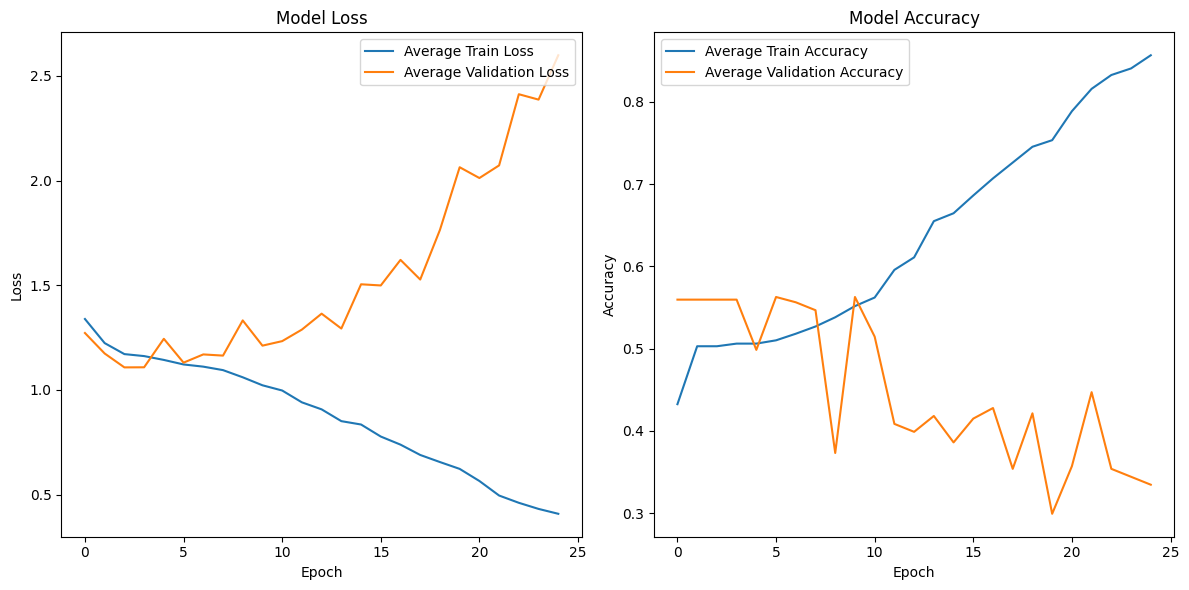

In [ ]:
#No point in training this further, graphs to understand
plot_history(conv3d_2d_lstm_model_history)

In [ ]:
# Generate the classification_report
predictions = weather_satellite_model.predict([weather_val, cloud_val])
# Convert probabilities to class labels
predicted_labels = np.argmax(predictions, axis=-1)
predicted_labels.shape
from sklearn.metrics import classification_report
# Compare predicted labels with true labels
print(classification_report(rain_val_b_mod, predicted_labels))

pred_df = pd.DataFrame([predicted_labels.flatten(), rain_val_c_mod]).T
pred_df.columns = ['predicted', 'actual']
pred_df["Predictions_correct"] = pred_df["predicted"] == pred_df["actual"]
print(pred_df[pred_df['actual'] == 0].value_counts())
print(pred_df[pred_df['actual'] == 1].value_counts())
print(pred_df[pred_df['actual'] == 2].value_counts())
print(pred_df[pred_df['actual'] == 3].value_counts())


10/10 [==============================] - 4s 157ms/step
              precision    recall  f1-score   support

           0       0.60      0.59      0.60       149
           1       0.35      0.37      0.36        93
           2       0.10      0.10      0.10        21
           3       0.30      0.29      0.29        48

    accuracy                           0.44       311
   macro avg       0.34      0.34      0.34       311
weighted avg       0.45      0.44      0.44       311

predicted  actual  Predictions_correct
0          0       True                   79
1          0       False                  58
3          0       False                  25
2          0       False                  12
Name: count, dtype: int64
predicted  actual  Predictions_correct
0          1       False                  37
1          1       True                   21
3          1       False                  14
2          1       False                   6
Name: count, dtype: int64
predicted  actual  P

#### MODIFIED Second Approach: Conv3D_LSTM + LSTM in an Encoder Decoder Architecture


Might be underfitting, so will try making it deeper

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, ConvLSTM2D, Flatten, TimeDistributed, Add, Reshape, Dense, BatchNormalization, Conv3D
from tensorflow.keras.optimizers import Adam

conv3d_2d_lstm_model_deep_checkpoint_path = r'/content/drive/MyDrive/Final Project Neural Nets/checkpoint/conv_3d_2d_lstm/model_deep_checkpoint1.h5'

# Defining input dimensions
weather_input = Input(shape=(24, 10))
satellite_input = Input(shape=(8, 48, 48, 1))

## Encoder Block

# Deep LSTM layers for weather data
weather_lstm1 = LSTM(128, return_sequences=True)(weather_input)
weather_dropout1 = Dropout(0.3)(weather_lstm1)
weather_lstm2 = LSTM(128, return_sequences=True)(weather_dropout1)
weather_dropout2 = Dropout(0.3)(weather_lstm2)
weather_lstm3 = LSTM(64, return_sequences=False)(weather_dropout2)
weather_dropout3 = Dropout(0.3)(weather_lstm3)

# Deep Conv3D and ConvLSTM layers for satellite imagery
sat_conv3d = Conv3D(filters=16, kernel_size=(3, 3, 3), padding='same', activation='relu')(satellite_input)
sat_dropout3d = Dropout(0.3)(sat_conv3d)
sat_conv_lstm1 = ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=True)(sat_dropout3d)
sat_dropout1 = Dropout(0.3)(sat_conv_lstm1)
sat_conv_lstm2 = ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True)(sat_dropout1)
sat_dropout2 = Dropout(0.3)(sat_conv_lstm2)
sat_conv_lstm_final = ConvLSTM2D(filters=128, kernel_size=(3, 3), padding='same', return_sequences=True)(sat_dropout2)
sat_dropout_final = Dropout(0.3)(sat_conv_lstm_final)
flat_features = TimeDistributed(Flatten())(sat_dropout_final)
satellite_lstm_out = LSTM(64, return_sequences=False)(flat_features)
satellite_batch_norm = BatchNormalization()(satellite_lstm_out)

# Integrating both feature sets
merged_features = Add()([weather_dropout3, satellite_batch_norm])

# Decoder Block
decoder_start = LSTM(128, return_sequences=True)(Reshape((1, 64))(merged_features))
decoder_dropout1 = Dropout(0.3)(decoder_start)
decoder_end = LSTM(64, return_sequences=False)(decoder_dropout1)
decoder_dropout2 = Dropout(0.3)(decoder_end)
predictions = Dense(4, activation='softmax')(decoder_dropout2)

# Model construction
weather_satellite_model_deep = Model(inputs=[weather_input, satellite_input], outputs=predictions)

# Model settings
lr_schedule = 0.0001
model_optimizer = Adam(learning_rate=lr_schedule)

weather_satellite_model_deep.compile(optimizer=model_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

weather_satellite_model_deep.summary()


Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_36 (InputLayer)       [(None, 8, 48, 48, 1)]       0         []                            
                                                                                                  
 conv3d_9 (Conv3D)           (None, 8, 48, 48, 16)        448       ['input_36[0][0]']            
                                                                                                  
 dropout_103 (Dropout)       (None, 8, 48, 48, 16)        0         ['conv3d_9[0][0]']            
                                                                                                  
 conv_lstm2d_36 (ConvLSTM2D  (None, 8, 48, 48, 32)        55424     ['dropout_103[0][0]']         
 )                                                                                         

In [ ]:
#Training the model
conv3d_2d_lstm_model_deep_history = []
conv3d_2d_lstm_model_deep_history.append(train(conv3d_2d_lstm_model_deep_checkpoint_path, weather_satellite_model , 25 ))

Epoch 1/25
125/125 [==============================] - ETA: 0s - loss: 0.3369 - accuracy: 0.8847
Epoch 1: val_loss improved from inf to 2.94573, saving model to /content/drive/MyDrive/Final Project Neural Nets/checkpoint/conv_3d_2d_lstm/model_deep_checkpoint1.h5
125/125 [==============================] - 26s 211ms/step - loss: 0.3369 - accuracy: 0.8847 - val_loss: 2.9457 - val_accuracy: 0.3505
Epoch 2/25
125/125 [==============================] - ETA: 0s - loss: 0.3244 - accuracy: 0.9015
Epoch 2: val_loss improved from 2.94573 to 2.81433, saving model to /content/drive/MyDrive/Final Project Neural Nets/checkpoint/conv_3d_2d_lstm/model_deep_checkpoint1.h5
125/125 [==============================] - 29s 234ms/step - loss: 0.3244 - accuracy: 0.9015 - val_loss: 2.8143 - val_accuracy: 0.3666
Epoch 3/25
125/125 [==============================] - ETA: 0s - loss: 0.2826 - accuracy: 0.9007
Epoch 3: val_loss did not improve from 2.81433
125/125 [==============================] - 26s 208ms/step - l

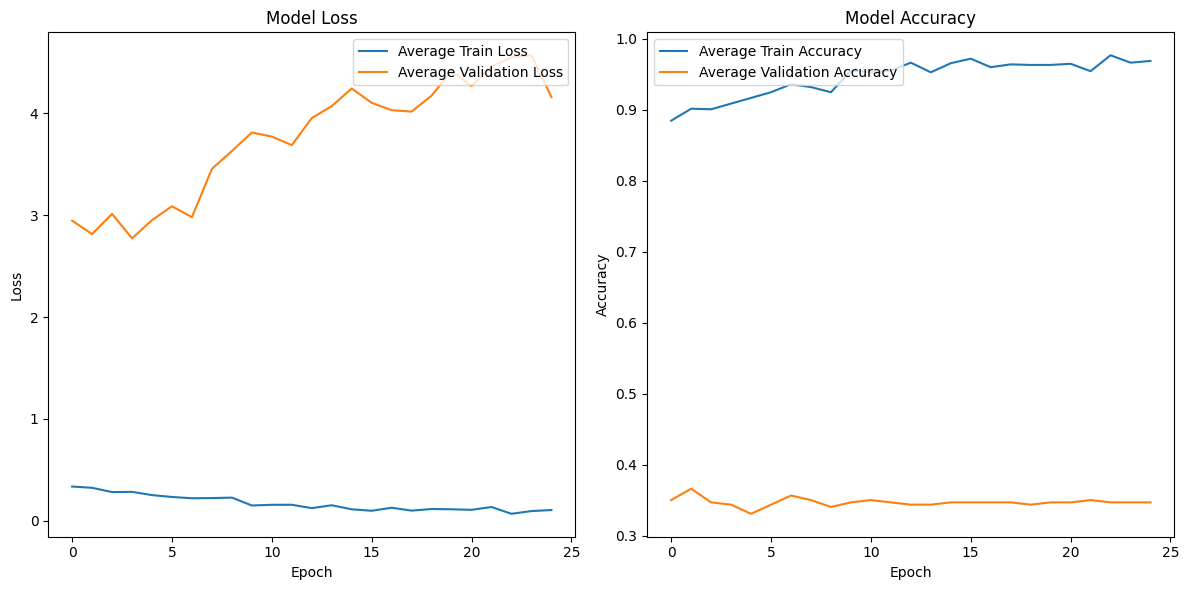

In [ ]:
#No point in training this further, graphs to understand
plot_history(conv3d_2d_lstm_model_deep_history)

In [ ]:
# Generate the classification_report
predictions = weather_satellite_model_deep.predict([weather_val, cloud_val])
# Convert probabilities to class labels
predicted_labels = np.argmax(predictions, axis=-1)
predicted_labels.shape
from sklearn.metrics import classification_report
# Compare predicted labels with true labels
print(classification_report(rain_val_b_mod, predicted_labels))

pred_df = pd.DataFrame([predicted_labels.flatten(), rain_val_c_mod]).T
pred_df.columns = ['predicted', 'actual']
pred_df["Predictions_correct"] = pred_df["predicted"] == pred_df["actual"]
print(pred_df[pred_df['actual'] == 0].value_counts())
print(pred_df[pred_df['actual'] == 1].value_counts())
print(pred_df[pred_df['actual'] == 2].value_counts())
print(pred_df[pred_df['actual'] == 3].value_counts())


10/10 [==============================] - 5s 239ms/step
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       149
           1       0.00      0.00      0.00        93
           2       0.00      0.00      0.00        21
           3       0.00      0.00      0.00        48

    accuracy                           0.48       311
   macro avg       0.12      0.25      0.16       311
weighted avg       0.23      0.48      0.31       311

predicted  actual  Predictions_correct
0          0       True                   174
Name: count, dtype: int64
predicted  actual  Predictions_correct
0          1       False                  78
Name: count, dtype: int64
predicted  actual  Predictions_correct
0          2       False                  21
Name: count, dtype: int64
predicted  actual  Predictions_correct
0          3       False                  38
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Trying with increased slices (48 hours)

We have to run all the pre-pressing steps first

In [ ]:
weather_train_batched_48 = tf.keras.preprocessing.timeseries_dataset_from_array(meteo_les[0:30000], None, 48, sequence_stride=24,
                                                                   sampling_rate=1, batch_size=30000)
for batch in weather_train_batched_48:
    print(batch.shape)
    print('--')

(1249, 48, 11)
--


In [ ]:
def convert_byte_tensor_to_float(tensor):
    string_tensor = tf.strings.regex_replace(tensor, '^b\'(.*)\'$', '\\1')
    float_tensor = tf.strings.to_number(string_tensor, out_type=tf.float32)
    return float_tensor

In [ ]:
weather_train_48 = None
for batch in weather_train_batched_48:
    weather_train_48 = batch
    print(weather_train_48.shape)
    print('--')

(1249, 48, 11)
--


In [ ]:
weather_train_48 = tf.map_fn(
    lambda batch: tf.map_fn(
        lambda sample: convert_byte_tensor_to_float(sample),
        batch,
        dtype=tf.float32),
    weather_train_48,
    dtype=tf.float32)

In [ ]:
cloud_train_batched_48 = tf.keras.preprocessing.timeseries_dataset_from_array(images[:10000], None, 16, sequence_stride=8,
                                                                           sampling_rate=1, batch_size=10000)

cloud_val_batched_48 = tf.keras.preprocessing.timeseries_dataset_from_array(images[:2500], None, 16, sequence_stride=8,
                                                                         sampling_rate=1, batch_size=2500)

print(cloud_train_batched_48)
print(cloud_val_batched_48)

<_BatchDataset element_spec=TensorSpec(shape=(None, None, 48, 48), dtype=tf.uint8, name=None)>
<_BatchDataset element_spec=TensorSpec(shape=(None, None, 48, 48), dtype=tf.uint8, name=None)>


In [ ]:
cloud_train_48 = None
for batch in cloud_train_batched_48:
    cloud_train_48 = batch
    cloud_train_48 = np.expand_dims(cloud_train_48, axis=-1)
    print(cloud_train_48.shape)
    cloud_train_48 = cloud_train_48 / 255
    print('--')

(1249, 16, 48, 48, 1)
--


In [ ]:
cloud_val_48 = None
for batch in cloud_val_batched_48:
    cloud_val_48 = batch
    cloud_val_48 = np.expand_dims(cloud_val_48, axis=-1)
    print(cloud_val_48.shape)
    cloud_val_48 = cloud_val_48 / 255
    print('--')

(311, 16, 48, 48, 1)
--


In [ ]:
rain_train_48 = []

for sample in weather_train_48:
    last_column = sample[:, -1]
    last_column = tf.cast(last_column, tf.float32)

    # Sum the values in the last column
    #print(last_column)
    rain_sum = tf.reduce_sum(last_column)

    # Append the sum to rain_train
    rain_train_48.append(rain_sum)

rain_train_48 = tf.stack(rain_train_48)

In [ ]:
rain_train_b_48 = tf.where(rain_train_48 > 0.1, 3,
                        tf.where(rain_train_48 > 0.05, 2,
                                 tf.where(rain_train_48 > 0.001, 1, 0)))

In [ ]:

weather_val_batched_48 = tf.keras.preprocessing.timeseries_dataset_from_array(meteo_les[-7500:], None, 48, sequence_stride=24,
                                                                   sampling_rate=1, batch_size=7500)

In [ ]:
weather_val_48 = None
for batch in weather_val_batched_48:
    weather_val_48 = batch
    print(weather_val_48.shape)
    print('--')

(311, 48, 11)
--


In [ ]:
weather_val_48 = tf.map_fn(
    lambda batch: tf.map_fn(
        lambda sample: convert_byte_tensor_to_float(sample),
        batch,
        dtype=tf.float32),
    weather_val_48,
    dtype=tf.float32)

In [ ]:
rain_val_48= []

for sample in weather_val_48:
    last_column = sample[:, -1]

    rain_sum = tf.reduce_sum(last_column)

    rain_val_48.append(rain_sum)

rain_val_48 = tf.stack(rain_val_48)

In [ ]:
#Generating 4 labels for our validation dataset
rain_val_b_48 = tf.where(rain_val_48 > 0.1, 3,
                        tf.where(rain_val_48 > 0.05, 2,
                                 tf.where(rain_val_48 > 0.001, 1, 0)))

In [ ]:
weather_val_48 = weather_val_48[:, :, :-1]


In [ ]:
n_samples_val_48, n_timesteps_val_48, n_features_val_48 = weather_val_48.shape
weather_val_48 = tf.reshape(weather_val_48, [n_samples_val_48 * n_timesteps_val_48, n_features_val_48])
weather_val_48 = weather_val_48.numpy()
weather_val_48 = scaler.transform(weather_val_48)
weather_val_48 = tf.reshape(weather_val_48, [n_samples_val_48, n_timesteps_val_48, n_features_val_48]).numpy()

In [ ]:
weather_val_48.shape

(311, 48, 10)

In [ ]:
# Assign rain train c as array from rain train b
rain_train_c_48 = rain_train_b_48.numpy()
print(rain_train_c_48.shape)

rain_val_c_48 = rain_val_b_48.numpy()
print(rain_val_c_48.shape)

(1249,)
(311,)


In [ ]:
rain_train_c_mod_48 = [rain_train_c_48[x+1] for x in range(len(rain_train_c_48)-1)]
print(len(rain_train_c_mod_48))
rain_val_c_mod_48 = [rain_val_c_48[x+1] for x in range(len(rain_val_c_48)-1)]
print(len(rain_val_c_mod_48))

1248
310


In [ ]:
cloud_train_48.shape, rain_train_c_48.shape, cloud_val_48.shape, rain_val_c_48.shape

((1249, 16, 48, 48, 1), (1249,), (311, 16, 48, 48, 1), (311,))

In [ ]:
weather_train_48 = np.asarray(weather_train_48)
cloud_train_48 = np.asarray(cloud_train_48)
rain_train_c_mod_48 = np.asarray(rain_train_c_mod_48)

weather_val_48 = np.asarray(weather_val_48)
cloud_val_48 = np.asarray(cloud_val_48)
rain_val_c_mod_48 = np.asarray(rain_val_c_mod_48)

In [ ]:
# Drop the last value from each of the validation datasets
weather_val_48 = weather_val_48[:-1]
cloud_val_48 = cloud_val_48[:-1]

#Drop the last value from each of the training datasets
weather_train_48 = weather_train_48[:-1]
cloud_train_48 = cloud_train_48[:-1]

In [ ]:
weather_train_48 = weather_train_48[:, :, :-1]
print(weather_train_48.shape)

(1248, 48, 10)


In [ ]:
print(weather_train_48.shape, cloud_train_48.shape, rain_train_c_mod_48.shape, weather_val_48.shape, cloud_val_48.shape, rain_val_c_mod_48.shape)

(1248, 48, 10) (1248, 16, 48, 48, 1) (1248,) (310, 48, 10) (310, 16, 48, 48, 1) (310,)


In [ ]:
#First, we need to one-hot encode our labels
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)

rain_train_c_mod_ohe_48 = encoder.fit_transform(rain_train_c_mod_48.reshape(-1, 1))
rain_val_c_mod_ohe_48 = encoder.fit_transform(rain_val_c_mod_48.reshape(-1, 1))

rain_train_c_mod_ohe_48.shape, rain_val_c_mod_ohe_48.shape

((1248, 4), (310, 4))

#### The model with 48 slides on Meteorological data and 16 slides on Image data

CONV3D + CONV2DLSTM + LSTM

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, ConvLSTM2D, Flatten, TimeDistributed, Add, Reshape, Dense, BatchNormalization, Conv3D
from tensorflow.keras.optimizers import Adam

conv3d_2d_lstm_model_48window_checkpoint_path = r'/content/drive/MyDrive/Final Project Neural Nets/checkpoint/conv_3d_2d_lstm/model_checkpoint1_48window.h5'

# Defining input dimensions
weather_input = Input(shape=(48, 10))
satellite_input = Input(shape=(16, 48, 48, 1))

## Encoder Block

# LSTM layers for weather data
weather_lstm = LSTM(128, return_sequences=True)(weather_input)
weather_lstm = Dropout(0.3)(weather_lstm)
weather_lstm = LSTM(64, return_sequences=False)(weather_lstm)
weather_lstm = Dropout(0.3)(weather_lstm)

# Conv3D layer for satellite imagery
sat_conv3d = Conv3D(filters=16, kernel_size=(3, 3, 3), padding='same', activation='relu')(satellite_input)
sat_conv3d = Dropout(0.3)(sat_conv3d)

# ConvLSTM layers for spatial-temporal data
sat_conv_lstm1 = ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=True)(sat_conv3d)
sat_conv_lstm1 = Dropout(0.3)(sat_conv_lstm1)
sat_conv_lstm_final = ConvLSTM2D(filters=128, kernel_size=(3, 3), padding='same', return_sequences=True)(sat_conv_lstm1)
flat_features = TimeDistributed(Flatten())(sat_conv_lstm_final)
satellite_lstm_out = LSTM(64, return_sequences=False)(flat_features)
satellite_lstm_out = BatchNormalization()(satellite_lstm_out)

# Integrating both feature sets
merged_features = Add()([weather_lstm, satellite_lstm_out])

# Decoder Block
decoder_start = LSTM(128, return_sequences=True)(Reshape((1, 64))(merged_features))
decoder_start = Dropout(0.3)(decoder_start)
decoder_end = LSTM(64, return_sequences=False)(decoder_start)
decoder_end = Dropout(0.3)(decoder_end)
predictions = Dense(4, activation='softmax')(decoder_end)

# Model construction
weather_satellite_model_48window = Model(inputs=[weather_input, satellite_input], outputs=predictions)

# Model settings
lr_schedule = 0.0001
model_optimizer = Adam(learning_rate=lr_schedule)

weather_satellite_model_48window.compile(optimizer=model_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

weather_satellite_model_48window.summary()


Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_40 (InputLayer)       [(None, 16, 48, 48, 1)]      0         []                            
                                                                                                  
 conv3d_11 (Conv3D)          (None, 16, 48, 48, 16)       448       ['input_40[0][0]']            
                                                                                                  
 dropout_117 (Dropout)       (None, 16, 48, 48, 16)       0         ['conv3d_11[0][0]']           
                                                                                                  
 conv_lstm2d_41 (ConvLSTM2D  (None, 16, 48, 48, 32)       55424     ['dropout_117[0][0]']         
 )                                                                                         

In [ ]:
#Creating the train function for both our approaches. Just boiler plate code to reduce code blocks
def train_48(checkpoint_path,model,epoch_count=10):
    checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1)

    # Check if a checkpoint already exists
    if os.path.exists(checkpoint_path):
        print("Loading the last checkpoint.")
        model.load_weights(checkpoint_path)

    # Fit the model
    history = model.fit(
        [weather_train_48, cloud_train_48],
        rain_train_c_mod_ohe_48,
        epochs=epoch_count,
        batch_size=10,
        validation_data=([weather_val_48, cloud_val_48], rain_val_c_mod_ohe_48),
        # class_weight=class_weight_dict,
        callbacks=[checkpoint_callback])
    return history

In [ ]:
conv2d_lstm_model_history_48window = []
conv2d_lstm_model_history_48window.append(train_48(conv3d_2d_lstm_model_48window_checkpoint_path, weather_satellite_model_48window, 25 ))

Epoch 1/25
125/125 [==============================] - ETA: 0s - loss: 1.3769 - accuracy: 0.3261
Epoch 1: val_loss improved from inf to 1.38131, saving model to /content/drive/MyDrive/Final Project Neural Nets/checkpoint/conv_3d_2d_lstm/model_checkpoint1_48window.h5
125/125 [==============================] - 61s 396ms/step - loss: 1.3769 - accuracy: 0.3261 - val_loss: 1.3813 - val_accuracy: 0.3000
Epoch 2/25
125/125 [==============================] - ETA: 0s - loss: 1.3605 - accuracy: 0.3614
Epoch 2: val_loss improved from 1.38131 to 1.37274, saving model to /content/drive/MyDrive/Final Project Neural Nets/checkpoint/conv_3d_2d_lstm/model_checkpoint1_48window.h5
125/125 [==============================] - 50s 396ms/step - loss: 1.3605 - accuracy: 0.3614 - val_loss: 1.3727 - val_accuracy: 0.3516
Epoch 3/25
125/125 [==============================] - ETA: 0s - loss: 1.3361 - accuracy: 0.3654
Epoch 3: val_loss improved from 1.37274 to 1.36676, saving model to /content/drive/MyDrive/Final Pro

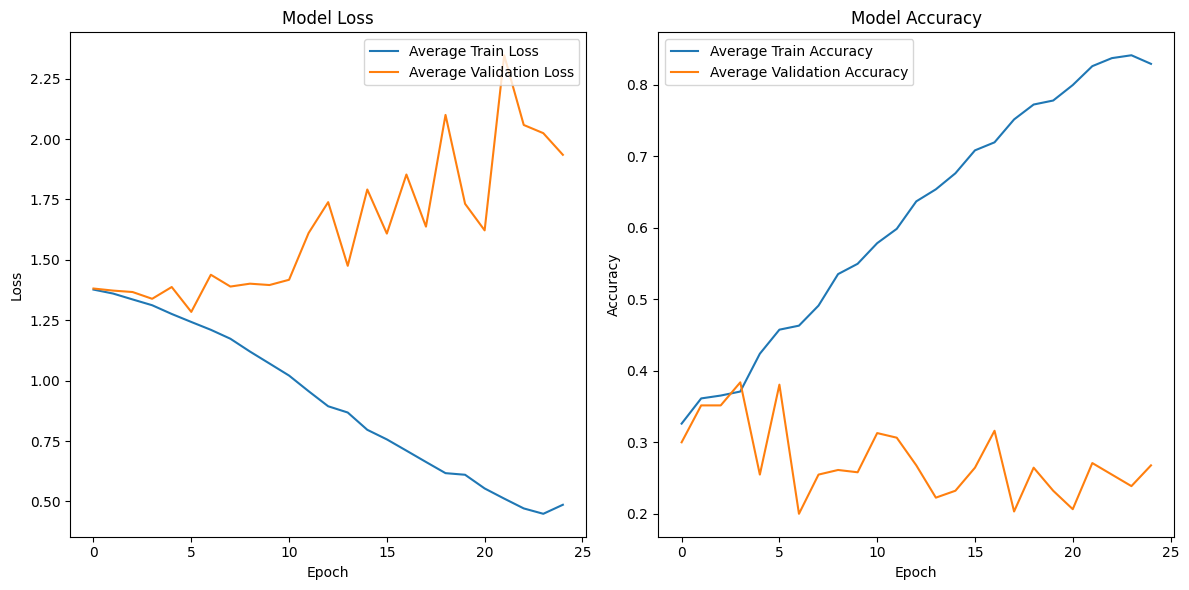

In [ ]:
#No point in training this further, graphs to understand
plot_history(conv2d_lstm_model_history_48window )

In [ ]:
# Generate the classification_report
predictions = weather_satellite_model_48window.predict([weather_val_48, cloud_val_48])
# Convert probabilities to class labels
predicted_labels = np.argmax(predictions, axis=-1)
predicted_labels.shape
from sklearn.metrics import classification_report
# Compare predicted labels with true labels
print(classification_report(rain_val_c_mod_48, predicted_labels))

pred_df = pd.DataFrame([predicted_labels.flatten(), rain_val_c_mod_48]).T
pred_df.columns = ['predicted', 'actual']
pred_df["Predictions_correct"] = pred_df["predicted"] == pred_df["actual"]
print(pred_df[pred_df['actual'] == 0].value_counts())
print(pred_df[pred_df['actual'] == 1].value_counts())
print(pred_df[pred_df['actual'] == 2].value_counts())
print(pred_df[pred_df['actual'] == 3].value_counts())


10/10 [==============================] - 3s 307ms/step
              precision    recall  f1-score   support

           0       0.36      0.32      0.34       119
           1       0.32      0.20      0.25        95
           2       0.09      0.29      0.14        24
           3       0.27      0.26      0.27        72

    accuracy                           0.27       310
   macro avg       0.26      0.27      0.25       310
weighted avg       0.31      0.27      0.28       310

predicted  actual  Predictions_correct
0          0       True                   38
2          0       False                  34
3          0       False                  24
1          0       False                  23
Name: count, dtype: int64
predicted  actual  Predictions_correct
0          1       False                  27
2          1       False                  25
3          1       False                  24
1          1       True                   19
Name: count, dtype: int64
predicted  actual  P